In [ ]:
!pip install yfinance ccxt

Epoch 1/50
43/43 [==============================] - 16s 234ms/step - loss: 0.6076 - val_loss: 0.5865 - lr: 0.0010
Epoch 2/50
 1/43 [..............................] - ETA: 5s - loss: 0.4489

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 8s 178ms/step - loss: 0.3326 - val_loss: 0.3699 - lr: 0.0010
Epoch 3/50
43/43 [==============================] - 7s 154ms/step - loss: 0.1502 - val_loss: 0.2259 - lr: 0.0010
Epoch 4/50
43/43 [==============================] - 8s 185ms/step - loss: 0.0494 - val_loss: 0.1550 - lr: 0.0010
Epoch 5/50
43/43 [==============================] - 6s 151ms/step - loss: 0.0158 - val_loss: 0.1325 - lr: 0.0010
Epoch 6/50
43/43 [==============================] - 8s 186ms/step - loss: 0.0084 - val_loss: 0.1245 - lr: 0.0010
Epoch 7/50
43/43 [==============================] - 7s 152ms/step - loss: 0.0049 - val_loss: 0.1141 - lr: 0.0010
Epoch 8/50
43/43 [==============================] - 8s 187ms/step - loss: 0.0028 - val_loss: 0.0967 - lr: 0.0010
Epoch 9/50
43/43 [==============================] - 6s 151ms/step - loss: 0.0023 - val_loss: 0.0864 - lr: 0.0010
Epoch 10/50
43/43 [==============================] - 8s 186ms/step - loss: 0.0021 - val_loss: 0.0760 - lr: 

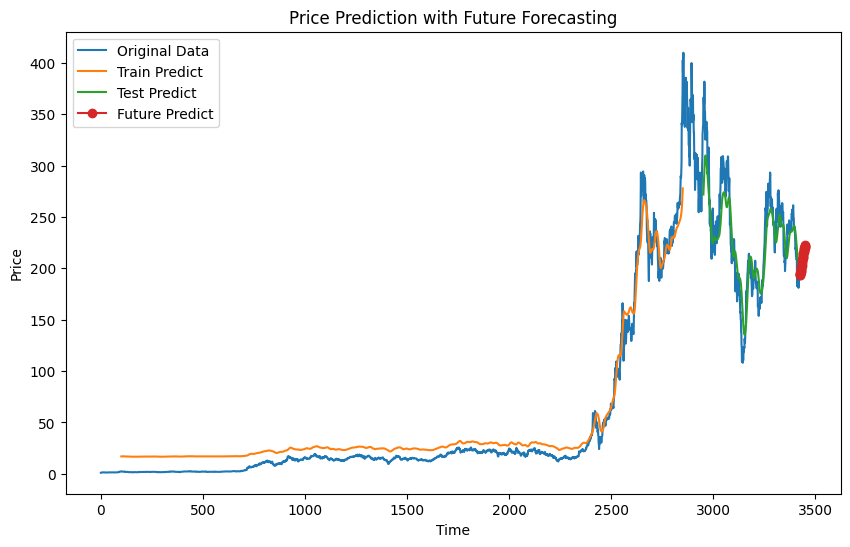

Train Score: 75.83 RMSE
Test Score: 228.04 RMSE
Total computation time: 457.70 seconds


In [11]:
import yfinance as yf
import ccxt
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import time

start_time = time.time()  # Start time of the computation

# Function to fetch stock data
def fetch_stock_data(ticker):
    stock = yf.Ticker(ticker)
    today = datetime.date.today()
    data = stock.history(period='1d', start='2010-01-01', end=today)
    data.reset_index(inplace=True)
    return data[['Date', 'Close']]

# Function to fetch cryptocurrency data
def fetch_crypto_data(symbol):
    exchange = ccxt.binance()  # Example uses Binance; adjust if necessary
    today = datetime.date.today()
    since = exchange.parse8601('2010-01-01T00:00:00Z')
    ohlcv = exchange.fetch_ohlcv(symbol, '1d', since=since)
    data = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    data['Date'] = pd.to_datetime(data['Date'], unit='ms')
    return data[['Date', 'Close']]

# User input for data source and ticker/symbol
data_source = input("Enter 'stock' for stock data or 'crypto' for cryptocurrency data: ").lower()
ticker_or_symbol = input("Enter the stock ticker or cryptocurrency symbol (e.g., AAPL for Apple stock or BTC/USDT for Bitcoin): ")

# Fetching data based on user input
if data_source == 'stock':
    data = fetch_stock_data(ticker_or_symbol)
elif data_source == 'crypto':
    data = fetch_crypto_data(ticker_or_symbol)
else:
    raise ValueError("Invalid data source. Please enter 'stock' or 'crypto'.")

# Preprocess the fetched data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Close'] = data['Close'].astype(float)

# Adding rolling mean as a feature for better prediction (Feature Engineering)
data['Rolling_Mean'] = data['Close'].rolling(window=5).mean().shift()
data.dropna(inplace=True)  # Drop rows with NaN values that are generated by rolling mean

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close', 'Rolling_Mean']])

# Splitting dataset into train and test sets dynamically
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(scaled_data):
    train, test = scaled_data[train_index], scaled_data[test_index]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Reshape input for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 2)  # Adjusted for 2 features
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 2)

# Model Building
model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True, input_shape=(time_step, 2), kernel_regularizer=l1_l2(l1=0.01, l2=0.01))),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='huber_loss')

# Callbacks for improved training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, verbose=1, mode='auto')
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Model Training
model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test),
          callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Load the best model
model = tf.keras.models.load_model('best_model.h5')

# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transformation for actual prediction values
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((len(train_predict), 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((len(test_predict), 1))), axis=1))[:, 0]

# Adjusting the dimensions for concatenation by reshaping the prediction arrays
train_predict_reshaped = train_predict.reshape(-1, 1)  # Reshape to 2D
test_predict_reshaped = test_predict.reshape(-1, 1)    # Reshape to 2D

# Future predictions section starts here
# User input for the number of future days to predict
future_days = int(input("Enter the number of days to predict into the future: "))

last_known_data = scaled_data[-time_step:]  # Taking the last known data
future_inputs = np.array(last_known_data).reshape(1, time_step, 2)

future_predictions = []
for i in range(future_days):
    future_pred = model.predict(future_inputs)[0, 0]
    future_inputs = np.append(future_inputs[:, 1:, :], [[[future_pred, 0]]], axis=1)
    future_predictions.append(future_pred)

# Inverse transform to get actual predicted values
future_predictions_scaled = np.array(future_predictions).reshape(-1, 1)
future_predictions_actual = scaler.inverse_transform(np.concatenate((future_predictions_scaled, np.zeros_like(future_predictions_scaled)), axis=1))[:, 0]

# Preparing the plot with correct dimensions including future predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(scaled_data)[:,0], label='Original Data')
plt.plot(np.concatenate((np.nan*np.zeros((time_step,1)), train_predict_reshaped, np.nan*np.zeros((len(test_predict_reshaped)+time_step,1)))), label='Train Predict')
plt.plot(np.concatenate((np.nan*np.zeros((len(train_predict_reshaped)+2*time_step,1)), test_predict_reshaped)), label='Test Predict')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_days), future_predictions_actual, label='Future Predict', marker='o')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Prediction with Future Forecasting')
plt.legend()
plt.show()

# Evaluation (Skipping future predictions)
trainScore = np.sqrt(mean_squared_error(y_train, train_predict[:len(y_train)]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, test_predict[:len(y_test)]))
print('Test Score: %.2f RMSE' % (testScore))

end_time = time.time()  # End time of the computation
print(f"Total computation time: {end_time - start_time:.2f} seconds")
